In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('C:/Users/HOME/Desktop/8차/통계학 세미나/팀플/잠재요인 돌릴때 쓰는 데이터/reviews.csv')
df.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [3]:
print(df.shape) #원본 데이터 900만개를 사용

(9073128, 10)


In [4]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating
0,271781,bluejacket74,4.03
1,125646,_dirty_,4.50
2,125646,CJDUBYA,4.75
3,125646,GratefulBeerGuy,4.58
4,125646,LukeGude,4.31


In [5]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
uid = df['userid'].values
df['user'] = user_enc.fit_transform(uid.tolist()) #array 인식이 안돼서 list로 빼냄.(userid의 경우만 오류 발생)
n_users = df['user'].nunique()

In [6]:
item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(164935, 309542, 1.0, 5.0)

In [7]:
df2=df[['user','beer','rating']] 
df2.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,user,beer,rating
0,102213,231507,4.03
1,94429,112229,4.50
2,15635,112229,4.75
3,34826,112229,4.58
4,55007,112229,4.31


In [8]:
#train, test 셋 분할: test size는 0.2, random_state는 임의로 지정
X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7258502, 2), (1814626, 2), (7258502,), (1814626,))

In [9]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

#X를 array로 만들기
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [10]:
beers = pd.read_csv('C:/Users/HOME/Desktop/8차/통계학 세미나/팀플/잠재요인 돌릴때 쓰는 데이터/beers.csv')
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [11]:
## create a dictionary out of beerid, beer original title
beers_dict = beers.set_index('id')['name'].to_dict()

In [12]:
##시각화(각 epoch마다의 MSE, MAE 값 비교)

def plot_history(hist):
    
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [rating]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Test Error')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$rating^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Test Error')
    plt.legend()
    plt.show()


In [13]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Nadam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda, Concatenate
from keras.layers import Embedding, Dense, Dropout

Using TensorFlow backend.


# 옵티마이저: nadam, test MSE; 0.1840, 과적합

In [14]:
#원래 함수(수정본2)
##bias가 있음, 아주 단순한 버전. 그냥 R_hat = u*m으로 연산한다. 최저 rating과 최고 rating을 이용한다.
##layer 2개를 추가하였고, activation 함수 2개는: relu와 sigmoid

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal')(x) 
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderV5(n_users, n_beers, n_factors, min_rating, max_rating):
    
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user) #u는 user * n_factor
    ub = EmbeddingLayer(n_users, 1)(user) #user_bias
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer) #b은 beer * n_factor
    bb = EmbeddingLayer(n_beers, 1)(beer) #beer_bias
    
    #input 연산- activation 2가지를 추가. relu와 sigmoid
    x = Concatenate()([u, b])
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)


    #최종 모델 만들기(input은 user, beer 2개를 받고, output은 x를 반환.)
    model = Model(inputs=[user, beer], outputs=x)
    opt = Nadam(lr=0.001) #learning rate(학습률) 설정. 
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer=opt) 

    return model

In [15]:
re5model = RecommenderV5(n_users, n_beers, n_factors, min_rating, max_rating)
re5model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        8246750     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        15477100    input_2[0][0]                    
____________________________________________________________________________________________

In [16]:
## fit model
import numpy as np
seed = 7
np.random.seed(seed)
history_mf5 = re5model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 


Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 3418s 471us/step - loss: 0.1998 - mae: 0.3176 - mse: 0.1998 - val_loss: 0.1810 - val_mae: 0.3003 - val_mse: 0.1810
Epoch 2/10
7258502/7258502 [==============================] - 3420s 471us/step - loss: 0.1702 - mae: 0.2909 - mse: 0.1702 - val_loss: 0.1772 - val_mae: 0.2972 - val_mse: 0.1772
Epoch 3/10
7258502/7258502 [==============================] - 3419s 471us/step - loss: 0.1613 - mae: 0.2825 - mse: 0.1613 - val_loss: 0.1766 - val_mae: 0.2954 - val_mse: 0.1766
Epoch 4/10
7258502/7258502 [==============================] - 3420s 471us/step - loss: 0.1552 - mae: 0.2766 - mse: 0.1552 - val_loss: 0.1771 - val_mae: 0.2959 - val_mse: 0.1771
Epoch 5/10
7258502/7258502 [==============================] - 3422s 471us/step - loss: 0.1502 - mae: 0.2719 - mse: 0.1502 - val_loss: 0.1782 - val_mae: 0.2968 - val_mse: 0.1782
Epoch 6/10
7258502/7258502 [==============================] 

In [17]:
## show loss & mae & mse at each epoch
hist5 = pd.DataFrame(history_mf5.history)
hist5['epoch'] = history_mf5.epoch
hist5

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.181025,0.300292,0.181025,0.199797,0.317573,0.199796,0
1,0.177242,0.297208,0.177242,0.170177,0.290907,0.170177,1
2,0.176592,0.295425,0.176592,0.161322,0.282512,0.161322,2
3,0.177078,0.295876,0.177078,0.155157,0.276622,0.155157,3
4,0.178202,0.296845,0.178202,0.150215,0.271855,0.150215,4
5,0.179326,0.297324,0.179326,0.146128,0.267915,0.146128,5
6,0.180886,0.299199,0.180886,0.142678,0.264545,0.142678,6
7,0.181632,0.299827,0.181632,0.139791,0.261682,0.139792,7
8,0.182713,0.300750,0.182713,0.137336,0.259245,0.137336,8
9,0.183990,0.302409,0.183990,0.135249,0.257130,0.135249,9


In [18]:
#모델 평가하기; model.evaluate() #test set에 평가했을 때, 맨 마지막 epoch의 val_loss, val_mae, val_mse
loss_and_metrics = re5model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 4s 2us/step
## evaluation loss and_metrics ##
[0.1839895945013914, 0.30240941047668457, 0.18398959934711456]


In [19]:
## get weights of the beers embedding matrix
beer_embedding_weights = re5model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights.shape

(309542, 50)

In [20]:
## import PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 309542)

In [21]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 79%로, 어느정도 성능이 좋다!

array([0.48229304, 0.10651259, 0.08234929], dtype=float32)

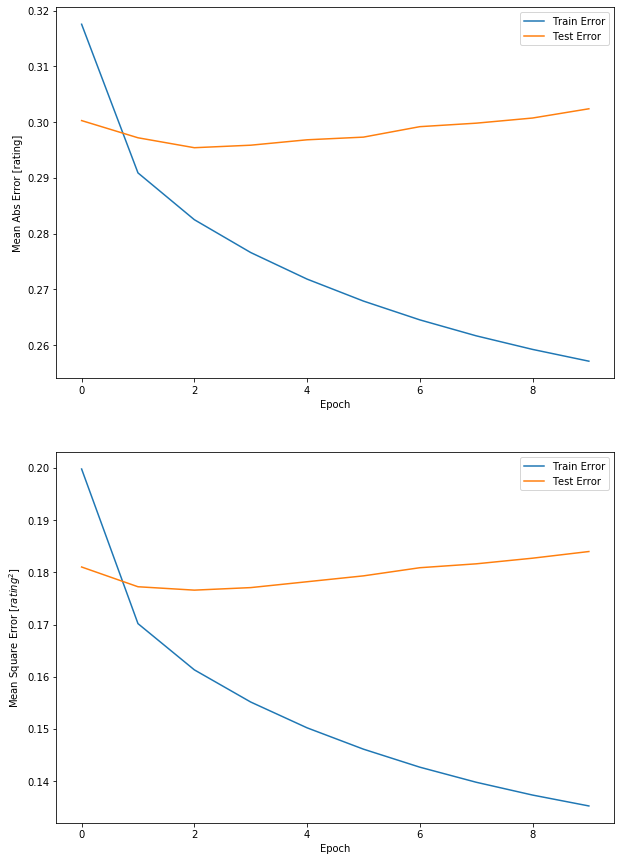

In [22]:
plot_history(hist5)